In [1]:
import numpy as np
from pydci.log import enable_log
from  pydci import SequentialMUDProblem
from pydci.examples.lotka_volterra import run_lv, lv_p1, lv_p2, lv_param_mins
import matplotlib.pyplot as plt
import importlib

enable_log()

[04/08/23 15:36:17] INFO     Logger initialized                                                           ]8;id=867105;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/log.py\log.py]8;;\:]8;id=5346;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/log.py#78\78]8;;\

<loguru.logger handlers=[(id=1, level=20, sink=<RichHandler (NOTSET)>)]>

# Static Models

In [90]:
from pydci import Model
import importlib
importlib.reload(Model)

class Monomial2D(Model.DynamicModel):
    
    def __init__(self,
                 p,
                 x0=[0, 0], # Note in the constant monomial case, initial state won't matter
                 lam_true=[0.5, 0.5],
                 solve_ts=1.0,
                 sample_ts=1.1,
                 measurement_noise=0.01,
                 **kwargs
                ):
        self.p = p
        super().__init__(x0, lam_true,
                         solve_ts=solve_ts,
                         sample_ts=sample_ts,
                         measurement_noise=measurement_noise,
                         **kwargs)

        
    def forward_model(
        self,
        x0,
        times,
        lam,
    ):
        """
        Monomial Forward Model
        """
        return np.array([[lam[0]**self.p, lam[1]**self.p]])
    
        
mm2 = Monomial2D(5)
lam = mm2.get_uniform_initial_samples(num_samples=1000, scale=0.5)
args = mm2.forward_solve(2.0, samples=lam)
# args


[04/11/23 02:07:31] INFO     Drawing 1000 from uniform at:                                             ]8;id=579070;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/Model.py\Model.py]8;;\:]8;id=704504;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/Model.py#232\232]8;;\
                                     loc: [0.25 0.25]                                                              
                                     scale: [0.5 0.5]                                                              

Solving model sample set: |████████████████████| 1000/1000 [100%] in 0.0s (43408


In [91]:
args['data']

,ts,shift_idx,sample_flag,lam_true_0,q_lam_true_0,q_lam_true_1,q_lam_obs_0,q_lam_obs_1
0,0.0,0,True,0.5,0.03125,0.03125,0.038784,0.033846
1,2.0,0,True,0.5,0.03125,0.03125,0.014246,0.050505


In [93]:
args['samples']

,lam_0,lam_1,q_lam_0,q_lam_1
0,0.360215,0.385040,0.006065,0.008463
1,0.496435,0.384641,0.030152,0.008419
2,0.533940,0.494035,0.043397,0.029430
3,0.332375,0.629358,0.004056,0.098739
4,0.311280,0.496112,0.002923,0.030054
...,...,...,...,...
995,0.627454,0.660833,0.097254,0.126025
996,0.652157,0.409488,0.117967,0.011513
997,0.631824,0.669924,0.100689,0.134936
998,0.463399,0.605182,0.021369,0.081176


# Lotka-Volter Model

In [14]:
importlib.reload(SequentialMUDProblem)
importlib.reload(Model)

np.random.seed(12345)

lv1_true_param = lv_p1
x0 = [2, 4]
param_shifts = None  # {17: lv_p2}

lvm_model = Model.DynamicModel(
    run_lv,
    x0,
    lv1_true_param,
    measurement_noise=0.2,
    solve_ts=0.1,
    sample_ts=1,
    param_mins=lv_param_mins,
    param_shifts=param_shifts,
)

In [74]:
import scipy.stats as sci
from scipy.stats._distn_infrastructure import rv_frozen

isinstance(nd, rv_frozen)

True

In [46]:
from scipy.stats.distributions import norm

nd = norm(loc=4*[0], scale=1)
nd.pdf(lvm_model.samples)

array([[0.07751636, 0.31176569, 0.32585651, 0.39749695],
       [0.14819467, 0.35444857, 0.3581926 , 0.39776083],
       [0.24296578, 0.34689807, 0.25541308, 0.3982046 ],
       ...,
       [0.27818955, 0.36404271, 0.3208755 , 0.39855396],
       [0.22193681, 0.37349741, 0.36447866, 0.39473889],
       [0.20917833, 0.37652604, 0.38348418, 0.39543019]])

In [62]:
type(nd)

scipy.stats._distn_infrastructure.rv_continuous_frozen

In [75]:
isinstance(nd_kde, gkde)

True

In [52]:
nd_kde = gkde(nd.rvs((10, 4)).T)

In [60]:
nd.rvs((10,4))

array([[-0.80714453,  0.90895421,  0.96613204, -0.27384416],
       [-0.58597453,  0.78968366,  0.29335223, -1.032171  ],
       [ 1.40169582, -1.54832953, -1.69023775,  2.34607986],
       [ 0.13320572, -0.88492957,  2.42210022,  0.45528291],
       [-1.71502955,  2.05234278, -0.87687267, -0.71555584],
       [-1.48732451, -1.97900899,  1.12435483,  1.52890074],
       [-1.47528197, -0.44860224, -0.83703713, -1.22078157],
       [ 1.28685648,  1.18636109, -0.41894273, -0.76050156],
       [-0.50904809, -0.44566154, -1.73131651, -0.19371986],
       [ 0.68346227,  0.75156647,  0.22662286, -0.80316674]])

In [58]:
nd_kde.resample(10).T

array([[-0.47805263, -1.8193262 ,  0.50908848, -1.38928556],
       [ 0.44093453, -0.43803968,  1.07877616,  0.09956637],
       [-0.12944998, -0.85658232, -0.60725422, -2.11267667],
       [-1.30654097, -1.05373894, -0.54803784, -2.20718011],
       [ 0.91070841,  1.14522229,  2.10119898,  2.24590405],
       [-1.29489038, -0.02354467,  1.07789388,  1.23433348],
       [-1.39692314, -2.28894947, -0.1577955 , -1.61117637],
       [-0.63693016,  2.20479769, -0.93224147,  1.01076384],
       [-0.01357225,  0.11673701, -0.53180566, -0.53277   ],
       [-1.19646682,  1.13543458,  0.88036949,  0.89007697]])

In [49]:
from scipy.stats import gaussian_kde as gkde
k = gkde(lvm_model.samples.T)
k.pdf(lvm_model.samples.T)

array([ 34.25764581,  85.0721872 ,  33.35847834,  34.35104122,
        83.96346495,  14.06600629,  15.42512177, 133.07522201,
        57.15054897,  54.61184498,  76.04837454,  82.5133292 ,
       205.35379762,  23.8139383 ,  64.91898929,  41.8043672 ,
        95.98788025, 124.71183335,  90.37538347,  17.13807988,
        20.14646363, 117.00586556,  84.23608113,  98.12938954,
        70.86557635,  46.27016016,  58.95815936,  22.77455088,
       135.12472048,  13.88704681,  81.28946683, 165.12256615,
       163.85921938, 152.15586416,  13.25784635, 117.84313828,
       180.43679209, 225.19420242,  71.01515451,  90.95181644,
        64.37141144, 176.93983896, 131.00270364,  34.8381484 ,
       166.56013289, 111.36693621,  49.67909785,  45.96550164,
        60.51311606, 143.81326972, 128.85475321, 136.38950251,
       175.4931179 ,  84.75535922,  58.55917448, 149.80205406,
       128.39787674,  14.02527791, 101.93276214, 148.26616599,
        29.33161352, 208.11008682, 187.35872816,  58.34

In [30]:
lvm_model.iterative_solve([0, 20, 40, 60], seed=12345)

Previous run exists. Do you want to reset state? y/(n) y


[04/08/23 15:45:26] INFO     Drawing 1000 from uniform at:                                             ]8;id=933782;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/Model.py\Model.py]8;;\:]8;id=424742;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/Model.py#246\246]8;;\
                                     loc: [0.55 0.2  0.25 0.05]                                                    
                                     scale: [1.1 0.4 0.5 0.1]                                                      

                    INFO     Starting solve over time : [0, 20, 40, 60]                                ]8;id=539918;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/Model.py\Model.py]8;;\:]8;id=456442;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/Model.py#295\295]8;;\

                    INFO     Iteration 0 [0, 20]:                                                      ]8;id=894812;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/Model.py\Model.py]8;;\:]8;id=769617;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/Model.py#298\298]8;;\

Solving model sample set: |████████████████████| 1000/1000 [100%] in 1.1s (943.3


[04/08/23 15:45:28] INFO     Drawing from updated distribution                                         ]8;id=5365;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/Model.py\Model.py]8;;\:]8;id=30870;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/Model.py#328\328]8;;\

                    INFO      Summary:                                                                 ]8;id=952912;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/Model.py\Model.py]8;;\:]8;id=886120;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/Model.py#316\316]8;;\
                             ┏━━━━━━━━┳━━━━━━━━┓                                                                   
                             ┃ Key    ┃ Value  ┃                                                                   
                             ┡━━━━━━━━╇━━━━━━━━┩                                                                   
                             │ Action │ UPDATE │                                                                   
                             │ NC     │ 1.0    │                                                                   
                             │ E(r)   │ 0.996  │                                                                   
                             │ KL     │ 2.964  │                                                                   
                             └────────┴────────┘                                                                   

                    INFO     Iteration 1 [19.095477386934675, 40]:                                     ]8;id=406528;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/Model.py\Model.py]8;;\:]8;id=742645;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/Model.py#298\298]8;;\

Solving model sample set: |████████████████████| 1000/1000 [100%] in 1.1s (1006.


[04/08/23 15:45:29] INFO     Drawing from updated distribution                                         ]8;id=426067;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/Model.py\Model.py]8;;\:]8;id=53626;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/Model.py#328\328]8;;\

                    INFO      Summary:                                                                 ]8;id=334682;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/Model.py\Model.py]8;;\:]8;id=253300;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/Model.py#316\316]8;;\
                             ┏━━━━━━━━┳━━━━━━━━┓                                                                   
                             ┃ Key    ┃ Value  ┃                                                                   
                             ┡━━━━━━━━╇━━━━━━━━┩                                                                   
                             │ Action │ UPDATE │                                                                   
                             │ NC     │ 1.0    │                                                                   
                             │ E(r)   │ 1.147  │                                                                   
                             │ KL     │ 2.998  │                                                                   
                             └────────┴────────┘                                                                   

                    INFO     Iteration 2 [39.19597989949749, 60]:                                      ]8;id=661466;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/Model.py\Model.py]8;;\:]8;id=160149;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/Model.py#298\298]8;;\

Solving model sample set: |████████████████████| 1000/1000 [100%] in 1.1s (833.0


[04/08/23 15:45:31] INFO     Drawing from updated distribution                                         ]8;id=899355;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/Model.py\Model.py]8;;\:]8;id=512134;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/Model.py#328\328]8;;\

                    INFO      Summary:                                                                 ]8;id=18337;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/Model.py\Model.py]8;;\:]8;id=37910;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/Model.py#316\316]8;;\
                             ┏━━━━━━━━┳━━━━━━━━┓                                                                   
                             ┃ Key    ┃ Value  ┃                                                                   
                             ┡━━━━━━━━╇━━━━━━━━┩                                                                   
                             │ Action │ UPDATE │                                                                   
                             │ NC     │ 1.0    │                                                                   
                             │ E(r)   │ 0.932  │                                                                   
                             │ KL     │ 3.344  │                                                                   
                             └────────┴────────┘                                                                   

In [31]:
lvm_model.mud_prob.result

,,nc,lam_MUD_0,lam_MUD_1,lam_MUD_2,lam_MUD_3,e_r,kl,predict_delta,within_thresh,closest,max_kl,min_kl,action
0,0,1.0,0.845559,0.34071,0.554334,0.085202,0.931922,3.343718,0.068078,True,True,True,True,UPDATE


In [32]:
np.linalg.norm(lvm_model.true_param - lvm_model.mud_prob.mud_point)

0.2672580945705205

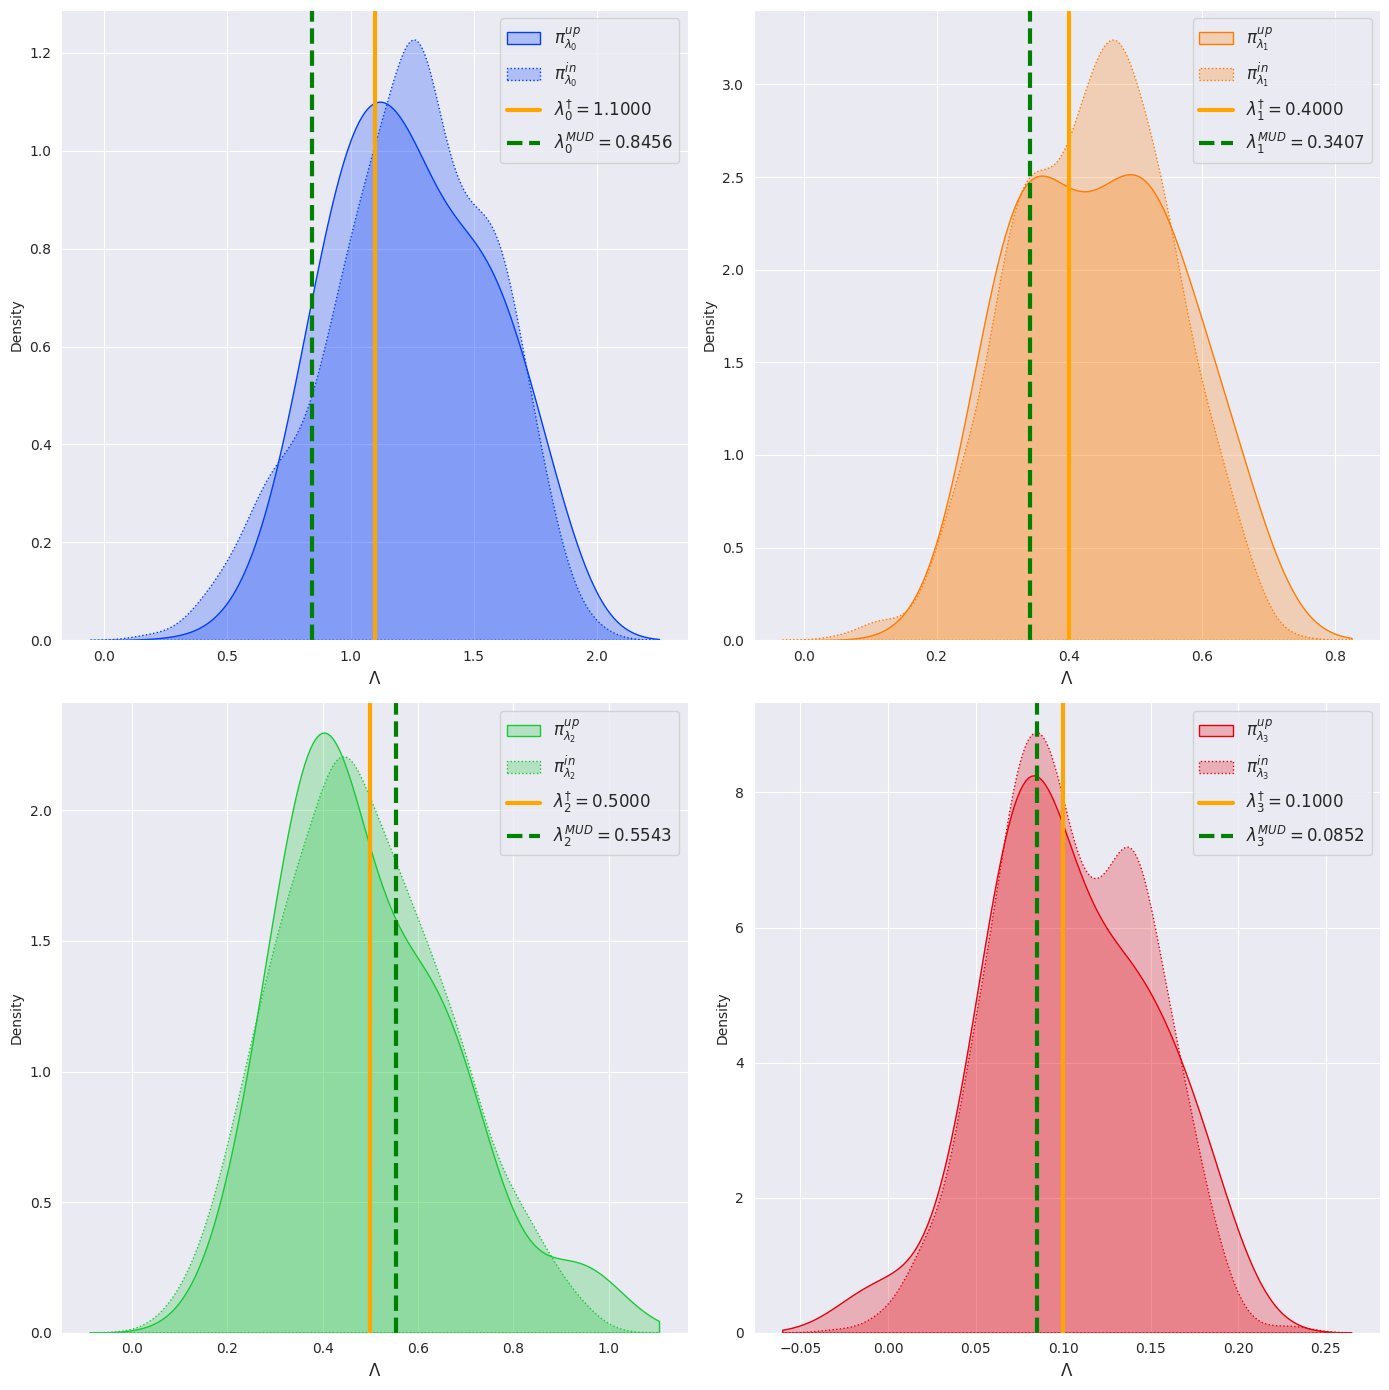

In [33]:
fig, ax = plt.subplots(2, 2, figsize=(14, 14))

_ = lvm_model.mud_prob.plot_param_state(param_idx=0, true_vals=[lvm_model.true_param], ax=ax[0][0])
_ = lvm_model.mud_prob.plot_param_state(param_idx=1, true_vals=[lvm_model.true_param], ax=ax[0][1])
_ = lvm_model.mud_prob.plot_param_state(param_idx=2, true_vals=[lvm_model.true_param], ax=ax[1][0])
_ = lvm_model.mud_prob.plot_param_state(param_idx=3, true_vals=[lvm_model.true_param], ax=ax[1][1])

## First iteration

In [65]:
args = lvm_model.mud_args(5, num_samples=1000)
lvm_model.x0, lvm_model.t0, args['data'].shape

AttributeError: 'DynamicModel' object has no attribute 'mud_args'

In [ ]:
lvm_model.state_df

### All data

In [ ]:
importlib.reload(SequentialMUDProblem)

qoi_method = 'all'
best_method = 'closest'

seq_mud_prob = SequentialMUDProblem.SequentialMUDProblem(
    *[args[x] for x in ['samples', 'q_lam', 'data', 'std_dev']],
    max_nc=args['max_nc'], qoi_method=qoi_method, best_method=best_method)

# Solve
seq_mud_prob.solve()

seq_mud_prob.result

In [ ]:
seq_mud_prob.mud_point

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
# sTODO: Plot in grid
for i, ax in enumerate(axes.flat):
    _, _ = seq_mud_prob.plot_param_state(param_idx=i, ax=ax, true_vals=[lv_p1])

### Full state/results

In [7]:
seq_mud_prob.results

nc  lam_MUD_0  lam_MUD_1  lam_MUD_2  lam_MUD_3       e_r        kl  \
0 0  1.0   0.928396   0.304639   0.450576   0.123107  0.993258  2.192209   
  1  2.0   0.796120   0.312239   0.562550   0.112705  0.537528  4.560920   
  2  3.0   1.149236   0.434757   0.623325   0.133766  0.493604  4.518462   
  3  4.0   1.149236   0.434757   0.623325   0.133766  0.502153  4.718305   

     predict_delta  within_thresh  closest  max_kl  min_kl  action  
0 0       0.006742           True     True   False    True  UPDATE  
  1       0.462472           True    False   False   False  UPDATE  
  2       0.506396          False    False   False   False    None  
  3       0.497847           True    False    True   False  UPDATE

In [8]:
seq_mud_prob.state

,weight,pi_in,pi_pr,pi_obs,ratio,pi_up,lam_0,lam_1,lam_2,lam_3,...,q_lam_4,q_lam_5,q_lam_6,q_lam_7,q_lam_8,q_lam_9,q_pca_0,q_pca_1,q_pca_2,q_pca_3
0,1.0,23.426354,0.022059,2.978249e-30,1.350156e-28,3.162924e-27,0.710581,0.534338,0.285691,0.111634,...,0.168796,2.922147,0.086633,2.213087,0.062535,1.667096,-11.581647,23.943907,3.961808,4.389224
1,1.0,18.064722,0.002093,0.000000e+00,0.000000e+00,0.000000e+00,1.643399,0.215450,0.381225,0.140231,...,6.847935,7.116063,4.579435,11.623056,1.676406,11.938977,68.229911,31.979267,-1.886250,11.331302
2,1.0,46.413416,0.023105,1.617166e-05,6.999151e-04,3.248545e-02,1.374766,0.524072,0.490251,0.090738,...,1.260183,1.940406,2.147637,1.367442,4.565577,1.112099,-4.497402,2.410613,-1.015259,1.247506
3,1.0,27.988828,0.005707,1.526809e-274,2.675095e-272,7.487277e-271,1.394563,0.258020,0.250521,0.119704,...,4.076511,4.922473,3.882176,6.291484,2.643042,7.287062,35.484256,18.580758,0.513972,7.860726
4,1.0,29.998073,0.004819,0.000000e+00,0.000000e+00,0.000000e+00,1.419107,0.362458,0.424240,0.052033,...,4.966167,2.100644,10.073740,1.996829,18.534926,2.752676,41.363929,-46.681982,-10.241898,-12.640172
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1.0,21.965513,0.016031,6.363228e-61,3.969248e-59,8.718657e-58,0.574422,0.573696,0.395852,0.120768,...,0.192884,2.043825,0.128321,1.390697,0.117471,0.942408,-16.594470,17.574854,3.870762,6.795196
996,1.0,16.140440,0.023485,3.577781e-08,1.523444e-06,2.458906e-05,1.622657,0.599266,0.430129,0.136991,...,0.976682,2.397464,1.431266,1.816614,2.728581,1.545471,-5.696841,10.948827,0.957188,3.369601
997,1.0,21.878528,0.012144,2.078196e-80,1.711229e-78,3.743916e-77,0.605841,0.556663,0.576063,0.052855,...,0.381757,1.296547,0.403819,0.735293,0.544556,0.418829,-19.107923,11.195905,2.669377,6.524899
998,1.0,44.333740,0.021906,4.668713e-02,2.131229e+00,9.448537e+01,1.115669,0.418016,0.545962,0.110479,...,1.618609,1.955484,2.500012,1.401713,4.555443,1.177930,-2.071400,1.495647,-0.011628,0.262548


In [9]:
seq_mud_prob.search_states

,pi_obs_0_nc=1,pi_pr_0_nc=1,ratio_0_nc=1,pi_up_0_nc=1,pi_obs_0_nc=2,pi_pr_0_nc=2,ratio_0_nc=2,pi_up_0_nc=2,pi_obs_0_nc=3,pi_pr_0_nc=3,ratio_0_nc=3,pi_up_0_nc=3,pi_obs_0_nc=4,pi_pr_0_nc=4,ratio_0_nc=4,pi_up_0_nc=4
0,1.017090e-59,0.009860,1.031549e-57,3.610931e-56,8.316007e-190,0.000189,4.393167e-186,1.537826e-184,9.311642e-195,0.000066,1.420059e-190,4.970909e-189,3.489914e-210,0.000018,1.917483e-205,6.712136e-204
1,6.727546e-32,0.022905,2.937214e-30,1.519809e-28,2.497332e-35,0.000641,3.893236e-32,2.014486e-30,9.582914e-36,0.000188,5.105989e-32,2.642003e-30,1.424393e-39,0.000026,5.440860e-35,2.815276e-33
2,5.582945e-92,0.011537,4.839267e-90,9.103071e-89,6.882749e-117,0.000472,1.458614e-113,2.743776e-112,1.989669e-118,0.000093,2.141864e-114,4.029027e-113,1.459375e-121,0.000013,1.118138e-116,2.103311e-115
3,6.172922e-03,0.018153,3.400408e-01,1.320512e+01,6.072993e-12,0.000494,1.229927e-08,4.776289e-07,3.961188e-15,0.000029,1.364880e-10,5.300363e-09,1.442475e-16,0.000009,1.638518e-11,6.363008e-10
4,5.617587e-04,0.022806,2.463164e-02,1.365279e+00,1.806565e-04,0.000661,2.732334e-01,1.514474e+01,5.911098e-05,0.000143,4.119782e-01,2.283506e+01,1.577212e-05,0.000042,3.750617e-01,2.078886e+01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,2.264669e-02,0.018531,1.222123e+00,6.326939e+01,6.451700e-03,0.000576,1.120241e+01,5.799493e+02,1.733177e-03,0.000145,1.192499e+01,6.173575e+02,6.266232e-04,0.000034,1.831252e+01,9.480400e+02
996,4.805138e-06,0.016741,2.870235e-04,5.998200e-03,7.351363e-08,0.000505,1.456742e-04,3.044292e-03,1.281494e-09,0.000049,2.600482e-05,5.434473e-04,1.372159e-10,0.000015,8.872094e-06,1.854085e-04
997,1.058520e-07,0.016196,6.535499e-06,3.469881e-04,6.963975e-19,0.000441,1.578831e-15,8.382462e-14,1.203433e-19,0.000135,8.938161e-16,4.745523e-14,1.953682e-23,0.000010,1.909236e-18,1.013667e-16
998,0.000000e+00,0.001232,0.000000e+00,0.000000e+00,0.000000e+00,0.000008,0.000000e+00,0.000000e+00,0.000000e+00,0.000004,0.000000e+00,0.000000e+00,0.000000e+00,0.000001,0.000000e+00,0.000000e+00


## Second iteration

Have to call `update_iteration` to feed in new samples, data and push_forwards. Note how we re-sample from updated distribution using `sample_update()` to get new set of samples to start from current system time.

In [10]:
samples = seq_mud_prob.sample_update(1000)
args = lvm_model.mud_args(10, samples=samples)
lvm_model.x0, lvm_model.t0, args['data'].shape

seq_mud_prob.update_iteration(
    args['samples'],  args['q_lam'], args['data'], args['std_dev'])
seq_mud_prob.solve()
seq_mud_prob.result

Solving model sample set: |████████████████████| 1000/1000 [100%] in 0.6s (1850.


,,nc,lam_MUD_0,lam_MUD_1,lam_MUD_2,lam_MUD_3,e_r,kl,predict_delta,within_thresh,closest,max_kl,min_kl,action
0,0,1.0,1.39856,0.512822,0.354764,0.067204,1.467346,6.675802,0.467346,True,True,True,True,UPDATE


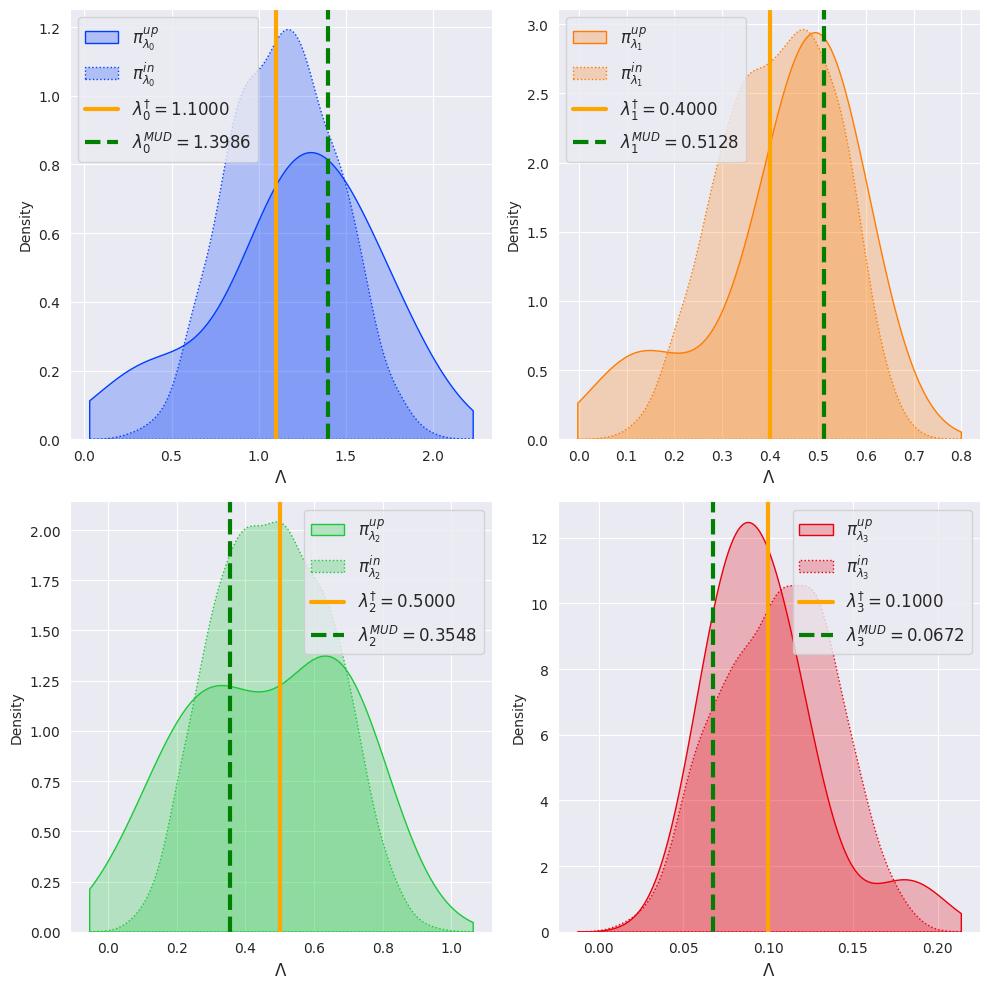

In [11]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
# sTODO: Plot in grid
for i, ax in enumerate(axes.flat):
    _, _ = seq_mud_prob.plot_param_state(param_idx=i, ax=ax, true_vals=[lv_p1])

## Third iteration

In [12]:
samples = seq_mud_prob.sample_update(1000)
args = lvm_model.mud_args(15, samples=samples)
lvm_model.x0, lvm_model.t0, args['data'].shape

# Update data 
seq_mud_prob.update_iteration(
    args['samples'],  args['q_lam'], args['data'], args['std_dev'])

# Solve

# Get result

seq_mud_prob.solve()

seq_mud_prob.result

on 223: /opt/conda/envs/pyDCI/lib/python3.11/site-packages/scipy/integrate/_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
          warnings.warn(warning_msg, ODEintWarning)


Solving model sample set: |████████████████████| 1000/1000 [100%] in 0.4s (2514.


,,nc,lam_MUD_0,lam_MUD_1,lam_MUD_2,lam_MUD_3,e_r,kl,predict_delta,within_thresh,closest,max_kl,min_kl,action
0,0,1.0,1.034392,0.357356,0.543591,0.103152,1.003457,2.090707,0.003457,True,True,False,True,UPDATE


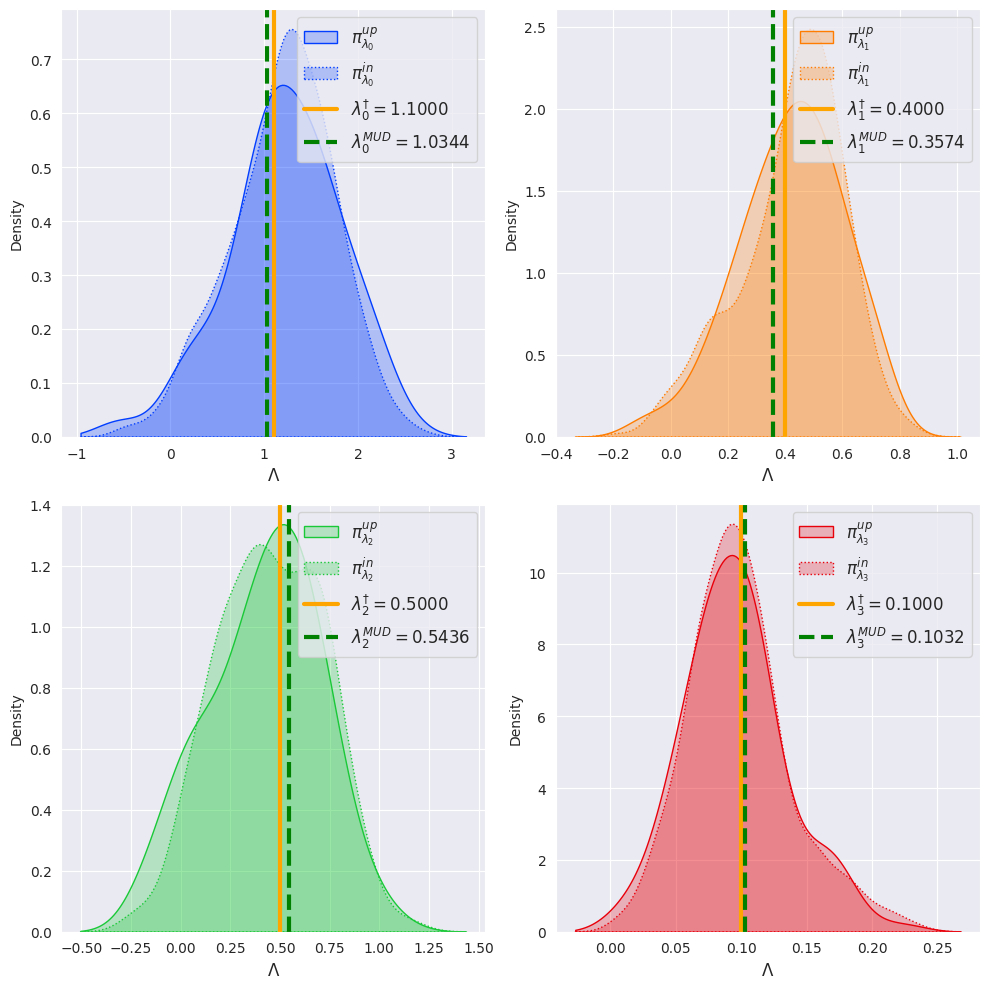

In [13]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
# sTODO: Plot in grid
for i, ax in enumerate(axes.flat):
    _, _ = seq_mud_prob.plot_param_state(param_idx=i, ax=ax, true_vals=[lv_p1])

In [14]:
## Fourth Iteration

In [15]:
samples = seq_mud_prob.sample_update(1000)
args = lvm_model.mud_args(29, samples=samples)
lvm_model.x0, lvm_model.t0, args['data'].shape

# Update data 
seq_mud_prob.update_iteration(
    args['samples'],  args['q_lam'], args['data'], args['std_dev'])

# Solve
seq_mud_prob.solve()

# Get result
seq_mud_prob.result

on 34: /opt/conda/envs/pyDCI/lib/python3.11/site-packages/scipy/integrate/_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
         warnings.warn(warning_msg, ODEintWarning)


Solving model sample set: |████████████████████| 1000/1000 [100%] in 0.9s (1053.


/opt/conda/envs/pyDCI/lib/python3.11/site-packages/scipy/stats/_entropy.py:135: RuntimeWarning: invalid value encountered in divide
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)
/opt/conda/envs/pyDCI/lib/python3.11/site-packages/scipy/stats/_entropy.py:135: RuntimeWarning: invalid value encountered in divide
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


,,nc,lam_MUD_0,lam_MUD_1,lam_MUD_2,lam_MUD_3,e_r,kl,predict_delta,within_thresh,closest,max_kl,min_kl,action
0,0,1.0,1.555119,0.5689,0.308218,0.048513,1.247737,5.424982,0.247737,True,True,True,True,UPDATE


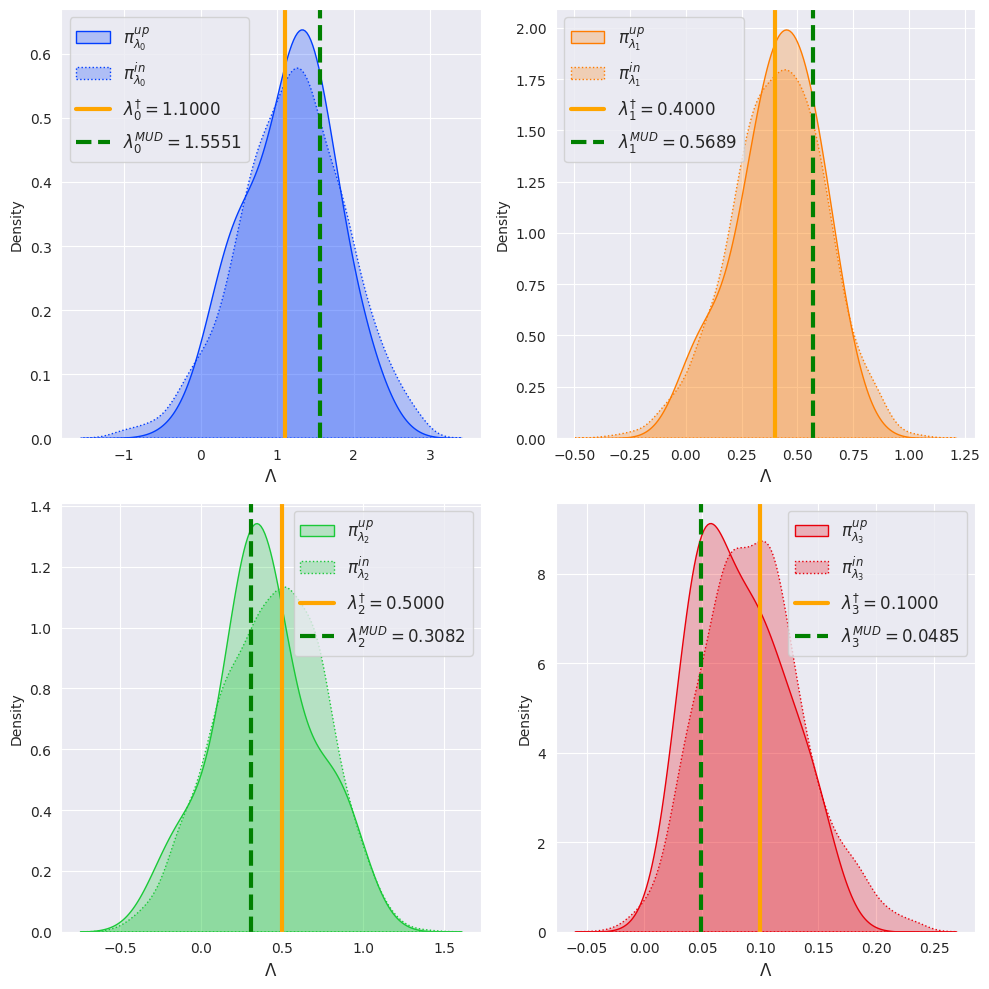

In [16]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
# sTODO: Plot in grid
for i, ax in enumerate(axes.flat):
    _, _ = seq_mud_prob.plot_param_state(param_idx=i, ax=ax, true_vals=[lv_p1])

# Split Sequential (No re-sampling)

In [28]:
lvm_model.state_df

,ts,shift_idx,sample_flag,true_param_0,true_vals_0,true_vals_1,obs_vals_0,obs_vals_1
0,14.285714,0,True,1.1,8.834351,1.438826,8.909709,1.154721
1,14.386497,0,False,1.1,9.302869,1.499048,NaN,NaN
2,14.487280,0,False,1.1,9.770562,1.569184,NaN,NaN
3,14.588063,0,False,1.1,10.230567,1.650309,NaN,NaN
4,14.688845,0,False,1.1,10.674684,1.743566,NaN,NaN
...,...,...,...,...,...,...,...,...
142,28.596869,0,False,1.1,1.385717,2.456918,NaN,NaN
143,28.697652,0,False,1.1,1.404684,2.369250,NaN,NaN
144,28.798434,0,False,1.1,1.428846,2.285206,NaN,NaN
145,28.899217,0,False,1.1,1.458252,2.204738,NaN,NaN
